In [1]:
# demonstrates how to implement a deep convolutional autoencoder for image denoising,
# mapoing noisy digits from the MNIST dataset to clean digits images

# This is based on 
# https://blog.keras.io/building-autoencoders-in-keras.html
# https://keras.io/examples/vision/autoencoder/


### Setup

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Prepare the data

In [4]:
# Since we only need images from the dataset to encode and decode, we 
# Won't use the labels.

# We are not training here 
# We are only decoding

(train_data, _), (test_data, _) = mnist.load_data()

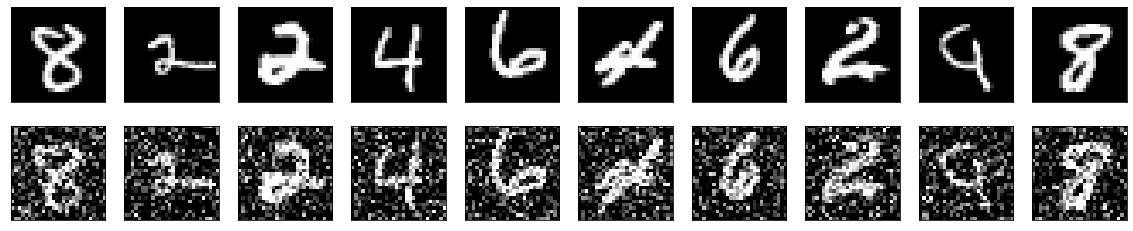

In [5]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

In [6]:
# We are going to use the Functional API to build our convolutional autoencoder.

input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248  

In [7]:
# Now We can train our autoencoder using train_data 
# as both our input data and target
# Notice we are setting up the validation data using the same format.


autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 7s 6ms/step - loss: 0.2594 - val_loss: 0.0725
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0718 - val_loss: 0.0690
Epoch 3/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0692 - val_loss: 0.0678
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0680 - val_loss: 0.0669
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0672 - val_loss: 0.0663
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0666 - val_loss: 0.0658
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0661 - val_loss: 0.0655
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0658 - val_loss: 0.0651
Epoch 9/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0653 - val_loss: 0.0648
Epoch 10/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0652 - val_loss: 0.0646

In [8]:
# Lets predict on our test dataset and display the original image together with the prediction form our autoencoder.
predictions = autoencoder.predict(test_data)

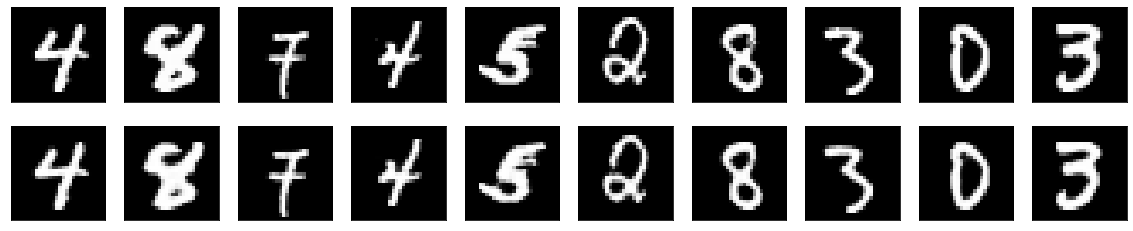

In [9]:
display(test_data, predictions)

In [10]:
# We know that our auto encoder works.
# lets retrain it using the noisy data as our input and the clean data as our target.
# we want our autoencoder to learn how to denoise the images.

In [12]:
autoencoder.fit(
    x = noisy_train_data,
    y = train_data,
    epochs=50, 
    batch_size = 128,
    shuffle = True,
    validation_data = (noisy_test_data, test_data))

Epoch 1/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1002 - val_loss: 0.0933
Epoch 2/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0929 - val_loss: 0.0912
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0913 - val_loss: 0.0900
Epoch 4/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0903 - val_loss: 0.0892
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0896 - val_loss: 0.0886
Epoch 6/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0890 - val_loss: 0.0882
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0885 - val_loss: 0.0877
Epoch 8/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0882 - val_loss: 0.0875
Epoch 9/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0879 - val_loss: 0.0874
Epoch 10/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0876 - val_loss: 0.0873

In [13]:
## lets predict on the noisy data and display the results of our autoencoder
## 

In [14]:
prediction= autoencoder.predict(noisy_test_data)

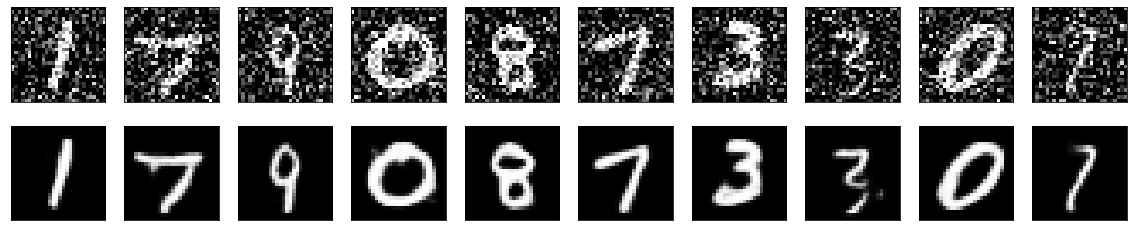

In [15]:
display(noisy_test_data, prediction)


### Thank you